# Sentiment Classification for IMDB Movie Reviews


In [99]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM, GRU, MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer

## Loading the Data

You will need to load the reviews. These are provided in the zip.
In addition, you will use pretrained embeddings (GloVe, 100d) which you need to download e.g. from https://nlp.stanford.edu/projects/glove/ .

In [21]:
movie_reviews = pd.read_csv("imdb_data/IMDB Dataset.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [22]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [23]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<AxesSubplot:xlabel='sentiment', ylabel='count'>

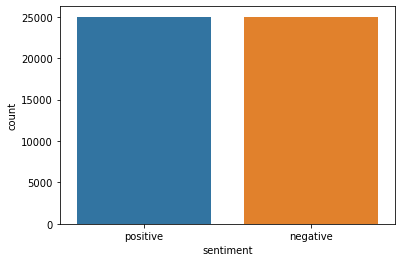

In [24]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)


## Preprocessing

__Prepare the review content__:

Remove 
* html tags
* replace punctuation with a space
* remove single characters
* remove multiple spaces

Split into train/test.

Tokenize the reviews - i.e. mapping the words to integers by using a vocabulary of the most frequent words.

Cut and pad the sequences to a given fixed length.

In [47]:
num_words = 5000
maxlen = 50

In [48]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [49]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [50]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Now the above sample review looks as follows - e.g. in teh first sentence, "there's a zombie" is replaced by just "there a zombie"

In [51]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

__Prepare the labels__

In [52]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

__Split into train/test__

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

__Tokenize__

In [54]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [55]:
vocab_size = len(tokenizer.word_index) + 1
print("Tokenizer has found %i words. When transforming texts to sequences words that have an index above %i are just ignored."%(vocab_size, num_words))

Tokenizer has found 92547 words. When transforming texts to sequences words that have an index above 5000 are just ignored.


In [56]:
indices = [0,1,2,3,4,5,6,4999,5000,10000]
for word, index in tokenizer.word_index.items():
    if index in indices:
        print("%s : %i"%(word,index))

the : 1
and : 2
of : 3
to : 4
is : 5
it : 6
secretly : 4999
joins : 5000
shattering : 10000


In [57]:
tokenizer.texts_to_sequences(["This is %s."%tokenizer.index_word[10000]])

[[8, 5]]

__Cutting and Padding__

In [58]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Utility

In [91]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [60]:
import sklearn
import pandas as pd
activities = ["neg", "pos"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.round(scores)
    labels = Y_test
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## A First Simple Model: Just an embedding layer and a dense layer 

In [61]:
# START YOUR CODE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
import numpy as np


nepochs = 10
embedding_dim = 32
batchsize = 512

model = tf.keras.Sequential()

model = Sequential()
model.add(Embedding(input_dim=num_words,output_dim=embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])


# END YOUR CODE

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 32)            160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1601      
Total params: 161,601
Trainable params: 161,601
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
79/79 [==============================] - 2s 16ms/step - loss: 0.6868 - acc: 0.5620 - val_loss: 0.6071 - val_acc: 0.7449
Epoch 2/10
79/79 [==============================] - 1s 10ms/step - loss: 0.5468 - acc: 0.7691 - val_loss: 0.4357 - val_acc: 0.8092
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.4008 - acc: 0.8300 - val_loss: 0.3908 - val_acc: 0.8254
Epoch 4/10
79/79 [==============================] - 1s 10ms/step - loss: 0.3470 - acc: 0.8519 - val_loss: 0.3793 - val_acc: 0.8294
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.3167 - acc: 0.8698 - val_loss: 0.3771 - val_acc: 0.8295
Epoch 6/10
79/79 [==============================] - 1s 10ms/step - loss: 0.2933 - acc: 0.8812 - val_loss: 0.3792 - val_acc: 0.8286
Epoch 7/10
79/79 [==============================] - 1s 12ms/step - loss: 0.2685 - acc: 0.8955 - val_loss: 0.3864 - val_acc: 0.8225
Epoch 8/10
79/79 [==============================] - 1s 12ms/step - loss: 0.2408 - acc

Train accuracy (end): 0.9606999754905701
Train accuracy (max): 0.9606999754905701
Test accuracy (end) : 0.8586999773979187
Test accuracy (max) : 0.8637999892234802


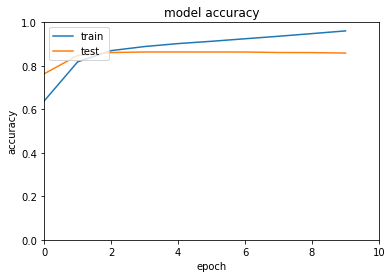

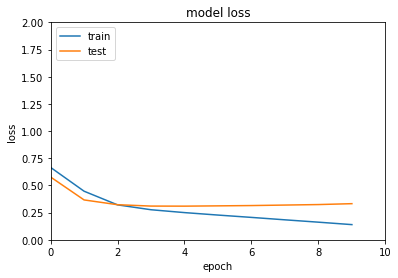

,neg,pos
neg,4320,641
pos,772,4267


In [41]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

We easily get into the overfitting regime since we have a huge amount of parameters.

## Using GloVe as pretrained embedding

In [63]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [64]:
maxlen = 50
embedding_matrix = np.zeros((num_words, maxlen))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None and index<num_words:
        embedding_matrix[index] = embedding_vector

In [79]:
# START YOUR CODE
nepochs = 10
embedding_dim = 50
batchsize = 128
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length = maxlen, trainable=True)
 

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])


# START YOUR CODE

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 50)            250000    
_________________________________________________________________
flatten_6 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2501      
Total params: 252,501
Trainable params: 252,501
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
hist2 = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
313/313 [==============================] - 3s 9ms/step - loss: 0.6532 - acc: 0.6207 - val_loss: 0.5035 - val_acc: 0.7596
Epoch 2/10
313/313 [==============================] - 2s 7ms/step - loss: 0.4591 - acc: 0.7880 - val_loss: 0.4434 - val_acc: 0.7921
Epoch 3/10
313/313 [==============================] - 2s 7ms/step - loss: 0.3837 - acc: 0.8269 - val_loss: 0.4246 - val_acc: 0.8024
Epoch 4/10
313/313 [==============================] - 2s 7ms/step - loss: 0.3418 - acc: 0.8525 - val_loss: 0.4231 - val_acc: 0.8071
Epoch 5/10
313/313 [==============================] - 3s 9ms/step - loss: 0.3057 - acc: 0.8719 - val_loss: 0.4104 - val_acc: 0.8126
Epoch 6/10
313/313 [==============================] - 2s 7ms/step - loss: 0.2768 - acc: 0.8870 - val_loss: 0.4226 - val_acc: 0.8097
Epoch 7/10
313/313 [==============================] - 2s 7ms/step - loss: 0.2444 - acc: 0.9063 - val_loss: 0.4304 - val_acc: 0.8120
Epoch 8/10
313/313 [==============================] - 2s 7ms/step - loss: 0.

Train accuracy (end): 0.9511749744415283
Train accuracy (max): 0.9511749744415283
Test accuracy (end) : 0.8026000261306763
Test accuracy (max) : 0.8126000165939331


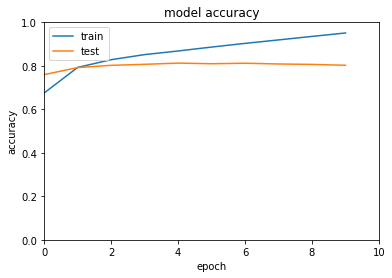

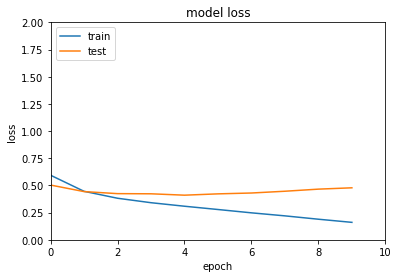

,neg,pos
neg,3975,986
pos,988,4051


In [83]:
performance_plots(model, X_test, y_test, hist2, nepochs)
confusion_matrix(model, X_test, y_test)

## Further Model / Hyper Parameter Combinations

Examples:

* Pretrained embedding (with GloVe), possibly fine-tuned
* dito + (SimpleRNN | LSTM | GRU | Conv1D)
* dito + stacked layers

For each combination, specify a cell with the model specification, one with the training and one with the evaluation (use for the latter the utilities provided).  


SimpleRNN

In [71]:
num_words = 5000

nepochs = 10
embedding_dim = 50
batchsize = 128

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=50, weights=[embedding_matrix]))
model.add(SimpleRNN(200))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 50)            250000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 200)               50200     
_________________________________________________________________
flatten_5 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               50250     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 251       
Total params: 350,701
Trainable params: 350,701
Non-trainable params: 0
________________________________________________

In [72]:
hist3 = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/10
313/313 [==============================] - 38s 116ms/step - loss: 0.6414 - accuracy: 0.6211 - val_loss: 0.5438 - val_accuracy: 0.7414
Epoch 2/10
313/313 [==============================] - 36s 115ms/step - loss: 0.4914 - accuracy: 0.7716 - val_loss: 0.5626 - val_accuracy: 0.7017
Epoch 3/10
313/313 [==============================] - 30s 96ms/step - loss: 0.4266 - accuracy: 0.8097 - val_loss: 0.5088 - val_accuracy: 0.7890
Epoch 4/10
313/313 [==============================] - 27s 87ms/step - loss: 0.3853 - accuracy: 0.8346 - val_loss: 0.4696 - val_accuracy: 0.8085
Epoch 5/10
313/313 [==============================] - 27s 87ms/step - loss: 0.3569 - accuracy: 0.8480 - val_loss: 0.4426 - val_accuracy: 0.8021
Epoch 6/10
313/313 [==============================] - 26s 83ms/step - loss: 0.3200 - accuracy: 0.8642 - val_loss: 0.4367 - val_accuracy: 0.8044
Epoch 7/10
313/313 [==============================] - 27s 87ms/step - loss: 0.2976 - accuracy: 0.8753 - val_loss: 0.4384 - val_accurac

Train accuracy (end): 0.9044250249862671
Train accuracy (max): 0.9044250249862671
Test accuracy (end) : 0.8087000250816345
Test accuracy (max) : 0.8145999908447266


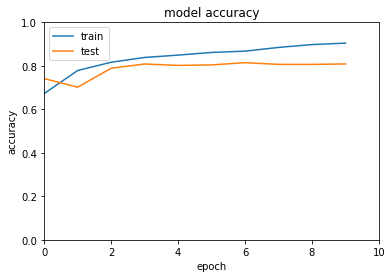

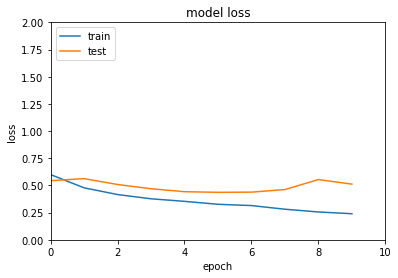

,neg,pos
neg,3743,1218
pos,695,4344


In [78]:
performance_plots(model, X_test, y_test, hist3, nepochs)
confusion_matrix(model, X_test, y_test)

LSTM

In [88]:
nepochs = 10
embedding_dim = 50
batchsize = 128

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=50, weights=[embedding_matrix]))
model.add(LSTM(50))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 50)            250000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
flatten_9 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 250)               12750     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 251       
Total params: 283,201
Trainable params: 283,201
Non-trainable params: 0
_______________________________________________

In [89]:
hist4 = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/10
313/313 [==============================] - 25s 67ms/step - loss: 0.5751 - accuracy: 0.6780 - val_loss: 0.4178 - val_accuracy: 0.8072
Epoch 2/10
313/313 [==============================] - 22s 71ms/step - loss: 0.3941 - accuracy: 0.8226 - val_loss: 0.3851 - val_accuracy: 0.8256
Epoch 3/10
313/313 [==============================] - 20s 65ms/step - loss: 0.3492 - accuracy: 0.8486 - val_loss: 0.4125 - val_accuracy: 0.8154
Epoch 4/10
313/313 [==============================] - 21s 66ms/step - loss: 0.3385 - accuracy: 0.8497 - val_loss: 0.3789 - val_accuracy: 0.8294
Epoch 5/10
313/313 [==============================] - 27s 87ms/step - loss: 0.3062 - accuracy: 0.8676 - val_loss: 0.3740 - val_accuracy: 0.8315
Epoch 6/10
313/313 [==============================] - 26s 83ms/step - loss: 0.2861 - accuracy: 0.8785 - val_loss: 0.3802 - val_accuracy: 0.8295
Epoch 7/10
313/313 [==============================] - 28s 88ms/step - loss: 0.2631 - accuracy: 0.8874 - val_loss: 0.3933 - val_accuracy:

Train accuracy (end): 0.9138249754905701
Train accuracy (max): 0.9138249754905701
Test accuracy (end) : 0.8209999799728394
Test accuracy (max) : 0.8314999938011169


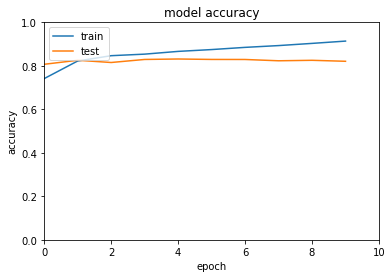

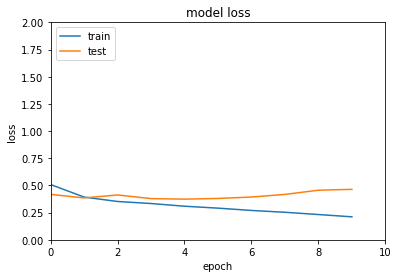

,neg,pos
neg,4069,892
pos,793,4246


In [92]:
performance_plots(model, X_test, y_test, hist4, nepochs)
confusion_matrix(model, X_test, y_test)

GRU

In [95]:
nepochs = 10
embedding_dim = 50
batchsize = 128

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=50, weights=[embedding_matrix]))
model.add(GRU(50))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 50)            250000    
_________________________________________________________________
gru (GRU)                    (None, 50)                15300     
_________________________________________________________________
flatten_10 (Flatten)         (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 250)               12750     
_________________________________________________________________
dropout_5 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 251       
Total params: 278,301
Trainable params: 278,301
Non-trainable params: 0
_______________________________________________

In [96]:
hist5 = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/10
313/313 [==============================] - 33s 93ms/step - loss: 0.6079 - accuracy: 0.6452 - val_loss: 0.4323 - val_accuracy: 0.7921
Epoch 2/10
313/313 [==============================] - 15s 49ms/step - loss: 0.3971 - accuracy: 0.8176 - val_loss: 0.3947 - val_accuracy: 0.8242
Epoch 3/10
313/313 [==============================] - 15s 49ms/step - loss: 0.3435 - accuracy: 0.8494 - val_loss: 0.3724 - val_accuracy: 0.8347
Epoch 4/10
313/313 [==============================] - 15s 47ms/step - loss: 0.3132 - accuracy: 0.8628 - val_loss: 0.3716 - val_accuracy: 0.8351
Epoch 5/10
313/313 [==============================] - 20s 63ms/step - loss: 0.2909 - accuracy: 0.8764 - val_loss: 0.3823 - val_accuracy: 0.8297
Epoch 6/10
313/313 [==============================] - 16s 50ms/step - loss: 0.2640 - accuracy: 0.8906 - val_loss: 0.3771 - val_accuracy: 0.8330
Epoch 7/10
313/313 [==============================] - 15s 49ms/step - loss: 0.2447 - accuracy: 0.9014 - val_loss: 0.3898 - val_accuracy:

Train accuracy (end): 0.9313750267028809
Train accuracy (max): 0.9313750267028809
Test accuracy (end) : 0.8235999941825867
Test accuracy (max) : 0.835099995136261


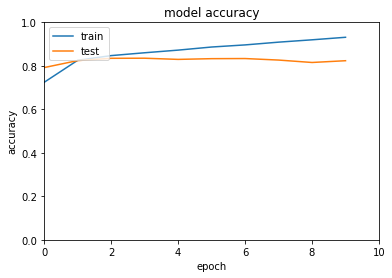

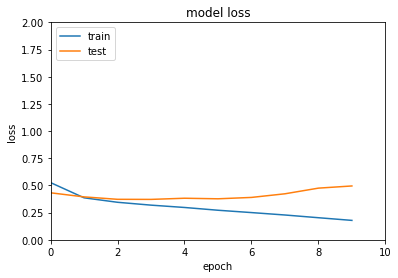

,neg,pos
neg,3971,990
pos,774,4265


In [97]:
performance_plots(model, X_test, y_test, hist5, nepochs)
confusion_matrix(model, X_test, y_test)

CNN

In [100]:
nepochs = 10
embedding_dim = 50
batchsize = 64

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=50, weights=[embedding_matrix]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=7)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 50, 50)            250000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 250)               200250    
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)               

In [101]:
hist6 = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/10
625/625 [==============================] - 14s 20ms/step - loss: 0.5971 - accuracy: 0.6605 - val_loss: 0.4206 - val_accuracy: 0.8029
Epoch 2/10
625/625 [==============================] - 10s 15ms/step - loss: 0.3788 - accuracy: 0.8279 - val_loss: 0.3850 - val_accuracy: 0.8249
Epoch 3/10
625/625 [==============================] - 8s 13ms/step - loss: 0.3050 - accuracy: 0.8690 - val_loss: 0.4096 - val_accuracy: 0.8112
Epoch 4/10
625/625 [==============================] - 10s 15ms/step - loss: 0.2425 - accuracy: 0.9011 - val_loss: 0.4283 - val_accuracy: 0.8117
Epoch 5/10
625/625 [==============================] - 10s 17ms/step - loss: 0.1716 - accuracy: 0.9356 - val_loss: 0.5680 - val_accuracy: 0.7927
Epoch 6/10
625/625 [==============================] - 8s 14ms/step - loss: 0.1028 - accuracy: 0.9625 - val_loss: 0.6472 - val_accuracy: 0.7955
Epoch 7/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0523 - accuracy: 0.9847 - val_loss: 0.7962 - val_accuracy: 0.

Train accuracy (end): 0.994825005531311
Train accuracy (max): 0.994825005531311
Test accuracy (end) : 0.8008999824523926
Test accuracy (max) : 0.8248999714851379


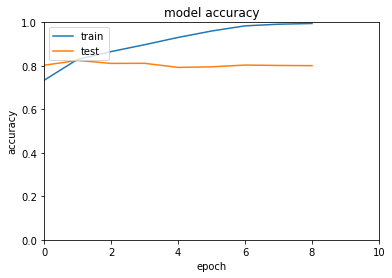

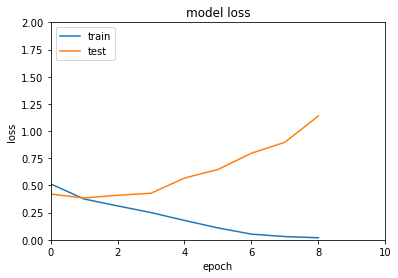

,neg,pos
neg,4052,909
pos,842,4197


In [102]:
performance_plots(model, X_test, y_test, hist6, nepochs)
confusion_matrix(model, X_test, y_test)

## Report with your Findings

With embedding, models with or without GloVe work good but we can observe overfitting on the model results. 
By using embedding layer with CNN, SimpleRNN, LSTM and GRU, we can observe that:

A) CNN model has the most overfitting eventhough the accuracy of Train set is the best (99%), accuracy of Test set is way less.
B) LSTM and GRU works really good.
C) The best tested model is GRU with Embedding and Dropout layers. (82.36% accuracy)
